In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk(r'C:\Users\insid\OneDrive\Desktop\Project DL'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



C:\Users\insid\OneDrive\Desktop\Project DL\exp-cnn-lstm.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\exp-lstm.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\IMDB Dataset.csv


In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\insid\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [15]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\insid\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\insid\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\insid\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\insid\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\insid\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping grammars\basque_grammars.zip.
[nltk_data]   

True

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Setting device to GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Setting device to CPU.")

CUDA is not available. Setting device to CPU.


In [17]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import pandas as pd


imdb_csv = r'C:\Users\insid\OneDrive\Desktop\Project DL\IMDB Dataset.csv'


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def load_imdb_dataset(csv_file):
    df = pd.read_csv(csv_file)
    reviews = []
    for _, row in df.iterrows():
        review = row['review']
        sentiment = 1 if row['sentiment'] == 'positive' else 0
        preprocessed_review = preprocess_text(review)
        reviews.append((preprocessed_review, sentiment))
    return reviews

class IMDBDataset(Dataset):
    def __init__(self, reviews, vocab_size=10000):
        self.reviews = reviews
        self.vocab_size = vocab_size
        self.word_to_idx = self.build_vocab()
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.sequence_length = max(len(review[0].split()) for review in reviews)
        
    def build_vocab(self):
        word_counts = {}
        for review, _ in self.reviews:
            for word in review.split():
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
        
        sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)[:self.vocab_size]
        return {word: idx for idx, word in enumerate(sorted_words)}
    
    def vectorize_review(self, review):
        vector = np.zeros(self.sequence_length, dtype=np.int64)
        for i, word in enumerate(review.split()):
            if i >= self.sequence_length:
                break
            vector[i] = self.word_to_idx.get(word, 0)
        return vector
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, index):
        review, sentiment = self.reviews[index]
        review_vector = self.vectorize_review(review)
        return torch.tensor(review_vector), torch.tensor(sentiment)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\insid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc(hidden)
        return torch.sigmoid(out)


In [55]:
from torch.utils.data import Dataset, DataLoader, random_split

In [22]:
vocab_size = 10000
embedding_dim = 100
hidden_dim = 128
output_dim = 1
batch_size = 64
num_epochs = 10
learning_rate = 0.001

reviews = load_imdb_dataset(imdb_csv)
dataset = IMDBDataset(reviews, vocab_size)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Epoch [1/40], Batch [100/547], Loss: 0.5298
Epoch [1/40], Batch [200/547], Loss: 0.4557
Epoch [1/40], Batch [300/547], Loss: 0.4652
Epoch [1/40], Batch [400/547], Loss: 0.4197
Epoch [1/40], Batch [500/547], Loss: 0.2612
Epoch [1/40], Train Loss: 0.4521, Val Loss: 0.3560
Epoch [2/40], Batch [100/547], Loss: 0.3652
Epoch [2/40], Batch [200/547], Loss: 0.2450
Epoch [2/40], Batch [300/547], Loss: 0.2573
Epoch [2/40], Batch [400/547], Loss: 0.3810
Epoch [2/40], Batch [500/547], Loss: 0.2994
Epoch [2/40], Train Loss: 0.2933, Val Loss: 0.3311
Epoch [3/40], Batch [100/547], Loss: 0.2835
Epoch [3/40], Batch [200/547], Loss: 0.1341
Epoch [3/40], Batch [300/547], Loss: 0.1890
Epoch [3/40], Batch [400/547], Loss: 0.2701
Epoch [3/40], Batch [500/547], Loss: 0.2774
Epoch [3/40], Train Loss: 0.2164, Val Loss: 0.3346
Epoch [4/40], Batch [100/547], Loss: 0.1624
Epoch [4/40], Batch [200/547], Loss: 0.1094
Epoch [4/40], Batch [300/547], Loss: 0.1934
Epoch [4/40], Batch [400/547], Loss: 0.1019
Epoch [4/40

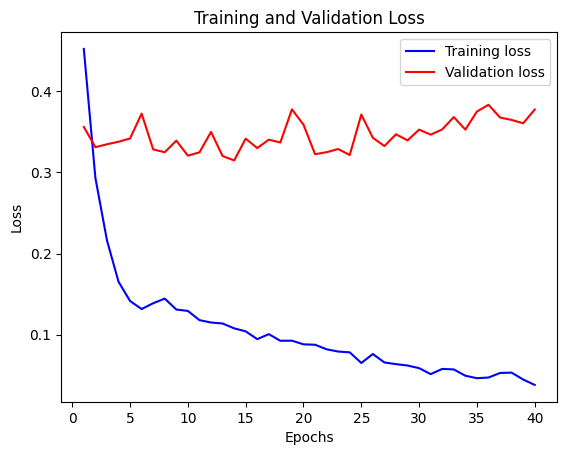

In [51]:
import torch.optim as optim

vocab_size = 10000  
embedding_dim = 300 
num_filters = 100  
kernel_sizes = [3, 4, 5] 
lstm_hidden_dim = 128 
learning_rate = 0.001 
num_epochs = 40  


model = SentimentLSTM(vocab_size, embedding_dim, num_filters, kernel_sizes, lstm_hidden_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCEWithLogitsLoss()  
# Add L2 regularization
l2_lambda = 0.001

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_lambda)

best_val_loss = float('inf')
patience = 5
counter = 0


train_losses = []
val_losses = []
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze() 
        loss = criterion(output, target.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            loss = criterion(output, target.float())
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [52]:

model.eval()  
total = 0
correct = 0
with torch.no_grad():  
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data).squeeze()
        predictions = torch.sigmoid(output) >= 0.5  
        total += target.size(0)
        correct += (predictions == target).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 88.07%


In [53]:
def predict_sentiment(model, sentence, dataset):
    model.eval()
    
    preprocessed_sentence = preprocess_text(sentence)
    
    vectorized_sentence = dataset.vectorize_review(preprocessed_sentence)
    vectorized_sentence = torch.tensor(vectorized_sentence).unsqueeze(0).to(device)
    
   
    with torch.no_grad():
        output = model(vectorized_sentence)
        predicted = torch.sigmoid(output).item()
    
   
    sentiment = 'Positive' if predicted >= 0.5 else 'Negative'
    confidence = predicted if predicted >= 0.5 else 1 - predicted
    
    return sentiment, confidence


sentences = [
    "This movie was fantastic! The acting was superb and the plot kept me engaged throughout.",
    "I was really disappointed with this book. The characters were poorly developed and the story was predictable.",
    "The restaurant had great ambiance, but the food was mediocre at best.",
    "I absolutely loved this song! It's catchy and the lyrics are meaningful."
]

for sentence in sentences:
    sentiment, confidence = predict_sentiment(model, sentence, dataset)
    print(f'Sentence: {sentence}')
    print(f'Predicted Sentiment: {sentiment}')
    print(f'Confidence: {confidence:.2f}')
    print('---')

Sentence: This movie was fantastic! The acting was superb and the plot kept me engaged throughout.
Predicted Sentiment: Positive
Confidence: 1.00
---
Sentence: I was really disappointed with this book. The characters were poorly developed and the story was predictable.
Predicted Sentiment: Negative
Confidence: 1.00
---
Sentence: The restaurant had great ambiance, but the food was mediocre at best.
Predicted Sentiment: Positive
Confidence: 0.96
---
Sentence: I absolutely loved this song! It's catchy and the lyrics are meaningful.
Predicted Sentiment: Positive
Confidence: 1.00
---
